Acknowledgement: Using as starting code from https://medium.com/@ankitvashisht12/classifying-dog-breed-using-pytorch-abc9f3c5128a

In [ ]:
import os
import torch
import pandas as pd
import numpy as np
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from collections import OrderedDict
%matplotlib inline
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = '/content/drive/My Drive/Colab Notebooks/SDDsubset'

dataset = ImageFolder(data)
print(f'{len(dataset)} images')

1233 images


In [ ]:
breeds = []
for n in dataset.classes:
    breeds.append(n)
print(breeds)

['bernese_mountain_dog', 'border_collie', 'chihuahua', 'golden_retriever', 'labrador_retriever', 'pug', 'siberian_husky']


In [ ]:
random_seed = 42
torch.manual_seed(random_seed)

In [ ]:
test_pct = 0.3
test_size = int(len(dataset)*test_pct)
dataset_size = len(dataset) - test_size

val_pct = 0.1
val_size = int(dataset_size*val_pct)
train_size = dataset_size - val_size


train_size, val_size, test_size

(778, 86, 369)

In [ ]:
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

(778, 86, 369)

pug
<class 'PIL.Image.Image'>


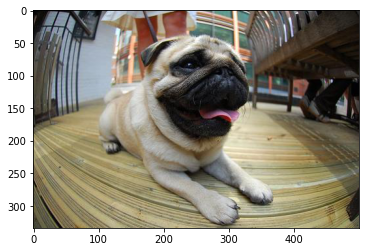

In [ ]:
img, label = train_ds[6]
print(dataset.classes[label])
plt.imshow(img)
print(type(img))

In [ ]:
class DogBreedDataset(Dataset):
    
    def __init__(self, ds, transform=None):
        self.ds = ds
        self.transform = transform
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        img, label = self.ds[idx]
        if self.transform:
            img = self.transform(img)  
            return img, label

In [ ]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_transform = transforms.Compose([
#    transforms.Resize((224, 224)),
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
    
])


val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
])

In [ ]:
train_dataset = DogBreedDataset(train_ds, train_transform)
val_dataset = DogBreedDataset(val_ds, val_transform)
test_dataset = DogBreedDataset(test_ds, test_transform)

5


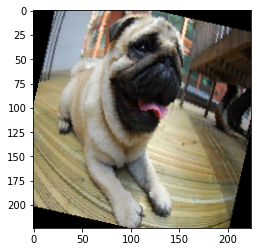

In [ ]:
img, label = train_dataset[6]
print(label)
plt.imshow(img.permute(1,2,0))

In [ ]:
batch_size =64

# Create DataLoaders
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size*2, num_workers=2, pin_memory=True)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class ImageClassificationBase(nn.Module):
    # training step
    def training_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        acc = accuracy(out, targets)
        return {'train_acc':acc.detach(), 'train_loss':loss}
    
    # validation step
    def validation_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        acc = accuracy(out, targets)
        return {'val_acc':acc.detach(), 'val_loss':loss.detach()}
    
    # validation epoch end
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}
        
    # print result end epoch
    def epoch_end(self, epoch, result):
        print("Epoch [{}] : train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}, train_acc: {:.4f}".format(epoch, result["train_loss"], result["val_loss"], result["val_acc"], result["train_acc"]))
        

Models

In [ ]:
class DogBreedClassificationCNN(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False),    # 16*224*224
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=False),

            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),   # 16*224*224
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),                    # 16*112*112

            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1, bias=False),    # 8*112*112
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=False),

            nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1, bias=False),     # 8*112*112
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),                    # 8*56*56

            # nn.Dropout(0.5), # w/wo
            nn.Flatten(),
            nn.Linear(8*56*56, 32),
            # nn.Dropout(0.5), # w/wo
            nn.LogSoftmax(dim=1),
        )
    
    def forward(self, xb):
        return self.network(xb)

In [ ]:
CNNmodel = DogBreedClassificationCNN()

In [ ]:
class DogBreedResnet18(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnet18(pretrained=False)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 7),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
resnet18model = DogBreedResnet18()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
class DogBreedPretrainedResnet18(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnet18(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 7),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

pretrained_resnet18model = DogBreedPretrainedResnet18()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
class DogBreedPretrainedResnet34(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 7),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

pretrained_resnet34model = DogBreedPretrainedResnet34()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
class DogBreedPretrainedResnext32(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnext101_32x8d(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 7),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

pretrained_resnext32model = DogBreedPretrainedResnext32()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_32X8D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth


  0%|          | 0.00/340M [00:00<?, ?B/s]

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(d, device) for d in data]
    else:
        return data.to(device, non_blocking=True)

In [ ]:
class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)

In [ ]:
# getting default device
device = get_default_device()

# moving train dataloader and val dataloader to gpu
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)


# moving model to gpu
to_device(pretrained_resnext32model, device)

DogBreedPretrainedResnext32(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
       

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func = torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # set up one cycle lr scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        
        # Training phase
        model.train()       
        train_losses = []
        train_acc = []
        lrs = []
        for batch in tqdm(train_loader):
            result = model.training_step(batch)
            

            train_acc.append(result['train_acc'])
            train_losses.append(result['train_loss'].detach())
            
            # calculates gradients
            result['train_loss'].backward()
            
            # check gradient clipping 
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            # perform gradient descent and modifies the weights
            optimizer.step()
            
            # reset the gradients
            optimizer.zero_grad()
            
            # record and update lr
            lrs.append(get_lr(optimizer))
            
            # modifies the lr value
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_acc).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        

    return history
        
    

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [ ]:
evaluate(pretrained_resnext32model, test_dl)

{'val_loss': 1.9589933156967163, 'val_acc': 0.17828170955181122}

In [ ]:
# set hyperparams
num_epochs = 5
opt_func = torch.optim.SGD

max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

In [ ]:
history = fit_one_cycle(num_epochs, max_lr, pretrained_resnext32model, train_dl, test_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/13 [00:00<?, ?it/s]

RuntimeError: ignored

In [ ]:
num_epochs = 3
max_lr = 0.001
history += fit_one_cycle(num_epochs, max_lr, pretrained_resnext32model, train_dl, test_dl, weight_decay, grad_clip, opt_func)

In [ ]:
num_epochs = 2
max_lr = 0.0001
history += fit_one_cycle(num_epochs, max_lr, pretrained_resnext32model, train_dl, test_dl, weight_decay, grad_clip, opt_func)

Plot

In [ ]:
history[0].keys()

In [ ]:
test_loss = []
train_loss = []
test_acc = []
train_acc = []
time = list(range(len(history)))
for h in history:
    test_loss.append(h['val_loss'])
    train_loss.append(h['train_loss'])
    test_acc.append(h['val_acc'])
    train_acc.append(h['train_acc'])
    

In [ ]:
plt.plot(time, test_loss, c='red', label='test_loss', marker='x')
plt.plot(time, train_loss, c='blue', label='train_loss', marker='x')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
plt.plot(time, test_acc, c='red', label='test_acc', marker='x')
plt.plot(time, train_acc, c='blue', label='train_acc', marker='x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [ ]:
lrs = np.concatenate([x.get('lrs', []) for x in history])
plt.xlabel('epochs')
plt.ylabel('lr')
plt.plot(lrs)
plt.show()

Task 5

In [ ]:
data = '/content/drive/My Drive/Colab Notebooks/task5'

dataset = ImageFolder(data)
print(f'{len(dataset)} images')

1879 images


In [ ]:
folders = []
for n in dataset.classes:
    folders.append(n)
print(folders)

['DBIsubset', 'SDDsubset']


In [ ]:
random_seed = 42
torch.manual_seed(random_seed)

In [ ]:
test_pct = 0.3
test_size = int(len(dataset)*test_pct)
train_size = len(dataset) - test_size

train_size, test_size

(1316, 563)

In [ ]:
train_ds, test_ds = random_split(dataset, [train_size, test_size])
len(train_ds), len(test_ds)

(1316, 563)

SDDsubset
<class 'PIL.Image.Image'>


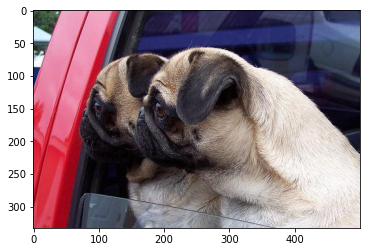

In [ ]:
img, label = train_ds[6]
print(dataset.classes[label])
plt.imshow(img)
print(type(img))

In [ ]:
train_ds = DogBreedDataset(train_ds, train_transform)
test_ds = DogBreedDataset(test_ds, test_transform)

In [ ]:
batch_size =64

# Create DataLoaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

In [ ]:
class DogBreedPretrainedResnext32(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnext101_32x8d(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 2),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

pretrained_resnext32model = DogBreedPretrainedResnext32()

In [ ]:
evaluate(pretrained_resnext32model, test_dl)

{'val_loss': 0.6979325413703918, 'val_acc': 0.5084763169288635}

In [ ]:
# set hyperparams
num_epochs = 5
opt_func = torch.optim.SGD

max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

In [36]:
history = fit_one_cycle(num_epochs, max_lr, pretrained_resnext32model, train_dl, test_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/21 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [0] : train_loss: 0.5788, val_loss: 0.5887, val_acc: 0.7321, train_acc: 0.6726


  0%|          | 0/21 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [1] : train_loss: 0.3239, val_loss: 0.4658, val_acc: 0.8415, train_acc: 0.8621


  0%|          | 0/21 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [2] : train_loss: 0.1890, val_loss: 0.4528, val_acc: 0.8172, train_acc: 0.9176


  0%|          | 0/21 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [3] : train_loss: 0.1155, val_loss: 0.3423, val_acc: 0.8580, train_acc: 0.9518


  0%|          | 0/21 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [4] : train_loss: 0.0471, val_loss: 0.2827, val_acc: 0.9062, train_acc: 0.9890


In [37]:
num_epochs = 3
max_lr = 0.001
history += fit_one_cycle(num_epochs, max_lr, pretrained_resnext32model, train_dl, test_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/21 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [0] : train_loss: 0.0422, val_loss: 0.2904, val_acc: 0.8971, train_acc: 0.9851


  0%|          | 0/21 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [1] : train_loss: 0.0255, val_loss: 0.2995, val_acc: 0.8810, train_acc: 0.9940


  0%|          | 0/21 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [2] : train_loss: 0.0238, val_loss: 0.2869, val_acc: 0.8932, train_acc: 0.9955


In [38]:
num_epochs = 2
max_lr = 0.0001
history += fit_one_cycle(num_epochs, max_lr, pretrained_resnext32model, train_dl, test_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/21 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [0] : train_loss: 0.0252, val_loss: 0.2910, val_acc: 0.8932, train_acc: 0.9940


  0%|          | 0/21 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [1] : train_loss: 0.0248, val_loss: 0.2917, val_acc: 0.8914, train_acc: 0.9963


In [39]:
history[0].keys()

dict_keys(['val_loss', 'val_acc', 'train_loss', 'train_acc', 'lrs'])

In [40]:
test_loss = []
train_loss = []
test_acc = []
train_acc = []
time = list(range(len(history)))
for h in history:
    test_loss.append(h['val_loss'])
    train_loss.append(h['train_loss'])
    test_acc.append(h['val_acc'])
    train_acc.append(h['train_acc'])

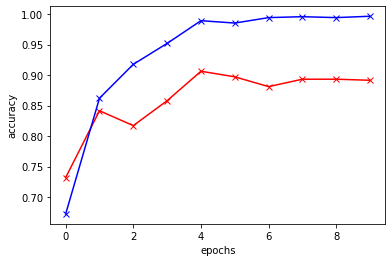

In [41]:
plt.plot(time, test_acc, c='red', label='test_acc', marker='x')
plt.plot(time, train_acc, c='blue', label='train_acc', marker='x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()